# Frequency Dependence of System-Bath Coupling:

## Single particle in 1-D junction with exponentially decaying interactions

1. Print input parameters
2. Generate Markovian random force for step (method of Bath class)
3. EOM integration step (e.g. velocity-Verlet) (method of MD class)
    1. Include possible arguments for Markovian Langevin dynamics
        1. Dissipation
        2. Random force
4. Calculate potential energy term for given configuration (method of Interaction class)
    1. Exponentially decaying interaction function
    2. Harmonic Oscillator
5. Calculate heat current and conductivity during a given step (method of MD class)
6. Print output results

Useful links:
1. http://codepad.org/FcbFcoue
2. http://gdrcorelec.ups-tlse.fr/files/python_verlet.pdf
3. http://docs.scipy.org/doc/numpy/reference/routines.html
4. http://ipython.org/ipython-doc/stable/interactive/index.html
5. http://nbviewer.ipython.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb

Further reading:
1. http://stackoverflow.com/questions/15374291/writing-a-faster-python-physics-simulator/15375757#15375757
2. http://dirac.cnrs-orleans.fr/MMTK/using-mmtk/mmtk-example-scripts/molecular-dynamics/an-md-integrator-written-in-python
3. http://www.sam.math.ethz.ch/~raoulb/teaching/PythonTutorial/
4. http://combichem.blogspot.co.il/
5. https://wiki.python.org/moin/PythonSpeed
6. https://wiki.python.org/moin/PythonSpeed/PerformanceTips
7. https://github.com/WeatherGod/AnatomyOfMatplotlib
8. http://ipython-books.github.io/cookbook/
9. https://docs.python.org/3/library/concurrency.html
10. http://stackoverflow.com/a/11075375
11. http://www.huyng.com/posts/python-performance-analysis/
12. http://scikit-learn.org/stable/developers/performance.html

##Note

1. To debug a crahsed program, insert "%debug" in a code cell following the trace-back. This will bring up the IPython Debugger (ipdb), which takes the usual shorthand:
    1. (c)ontinue
    2. (n)ext, a.k.a. step-over
    3. (s)tep into
    4. (b)reakpoint insert
2. Pretty-printing variable x, then all local variables and then all global variables:
    ```
    >>> import pprint
    >>> import pprint(x)
    >>> pprint.pprint(locals())
    >>> pprint.pprint(globals())
    ```

## System units:

### System characteristics

1. Characteristic distance ~ 1 $\AA$ (Angstrom) $\Rightarrow$ [x] $\equiv 1 \AA$
2. Characteristic mass ~ 1 a.m.u. $\Rightarrow$ [m] $\equiv$ 1 a.m.u.
3. Characteristic energy ~ 100 cm$^{-1} \Rightarrow$ [E] $\equiv$ 100 cm$^{-1}$

### Derived units:

1. Temperature = 100 cm$^{-1}$ $\times$ $k_B$ $\approx$ 144 Kelvin
    * $k_B$ = $1.38064 \times 10^{-23}$ J/K (Boltzmann constant in SI units)
2. Time = 1/ (100 cm$^{-1}$ $\times c$ [cm / s]) s = 1 / 29979245800 s $ \approx 33.35641 \times 10^{-12}$ s = 33.35641 ps $\Rightarrow$ [t] $\approx \frac{100}{3}$ ps
3. Speed = 1 Angstrom / 33.35641 ps = 1 Angstrom $\times$ 0.029979245800 ps$^{-1}$ = 0.029979245800 Angstrom / ps
4. Acceleration = 0.029979245800 Angstrom / ps $\times$ 0.029979245800 ps$^{-1}$ = 0.0008987551787 Angstrom / ps$^{-2}$
5. Momentum = 1 a.m.u. $\times$ 0.029979245800 Angstrom / fs = 0.029979245800 a.m.u. $\times$ Angstrom / ps

## Pylab magic:

In [2]:
# magic!
%pylab inline

##from math import exp
#import math

##from numpy import array, ndarray # dev note: why can't I import like this?
#import numpy as np

#import matplotlib.pyplot as plt
##from matplotlib import pyplot as plt
##import matplotlib as mpl
#"""
#try:
#    import matplotlib.pyplot as plt
#except:
#    raise
#"""

# from random import gauss

Populating the interactive namespace from numpy and matplotlib


## Global constants:

In [3]:
'''
System units:
length: 1 Angstrom
mass: 1 a.m.u.
time: from energy, using c
energy: 100 wavenumbers
'''
'''
energy scale ~ 100 wavenumbers
'''
WAVENUMBER_TO_SYS_UNITS = 1e-2
'''
100 wavenumbers ~= 3e12 Hz
==> linear frequency scale ~ 3 PHz
'''
'''
3e12 Hz ~= 18.85e12 rad / s
==> angular frequency scale ~ 2e13 rad/s
'''
'''
3e12 Hz ~= (33.3e-12 s)^(-1) = (33.3 picoseconds)^(-1)
==> time scale ~ 33.3 ps
'''
SPEED_OF_LIGHT_IN_CM_PER_SEC = 29979245800
#SECONDS_TO_SYS_UNITS = float(100) / 3e-12 # float(1) / (33.3e-12)
#PICOSECONDS_TO_SYS_UNITS = float(100) / 3
PICOSECONDS_TO_SYS_UNITS = float(1) / (1e-12 * SPEED_OF_LIGHT_IN_CM_PER_SEC) # ps to s: /1e-12, s to cm$^{-1}$: /$c$
'''
100 wavenumbers ~= 144 Kelvin
==> temperature scale ~ 144 Kelvin
'''
KELVIN_TO_SYS_UNITS = float(1) / 144
# mass scale ~ 1 a.m.u.

## Declaration of global variables:

In [4]:
N_DIM=1 # spatial dimensionality
N_ATOMS=3 # number of atoms in extended molecule (including surfaces of left and right bulk solids)

M0=float(16) # mass of particle, in a.m.u. (attribute of Particle class)
m=np.ones(N_ATOMS) # mass of each atom, in a.m.u.
x=np.zeros(shape=(N_ATOMS, N_DIM)) # position of each atom, in Angstroms
v=np.zeros(shape=(N_ATOMS, N_DIM)) # velocitiy of each atom, in Angstroms per picosecond
a=np.zeros(shape=(N_ATOMS, N_DIM)) # acceleration of each atom, in Angstroms per picosecond squared

binaryForces=np.zeros(shape=(N_ATOMS,N_ATOMS))

N_BATHS=2
M_B=M0 # mass of surface-representation particle, in a.m.u. (attribute of Particle class)
V0=float(8000) * WAVENUMBER_TO_SYS_UNITS # magnitude of particle-surface interaction, in wavenumbers (attribute of Interaction class). Default = 8000
A=float(0.1) # exponentially decaying interaction extinction coefficient in inverse Angstroms (attribute of Interaction class)
V0A2=float(0) # effective spring constant of the restoring force, in wavenumbers (attribute of Interaction class).
HARMONIC_APPROX=False # true if the harmonic approximation is to be taken
OMEGA_D=float(400) # Debye frequnecy bath, in wavenumbers (attribute of Bath class). Default = 400 (No support for Wide Band Approximation, Ohmic bath)
OMEGA_M=float(0) # inverse of bath memory duration, in wavenumbers (attribute of Bath class). Default = 0 (Markovian bath)
OMEGA_B=float(0) # oscillation frequency of surface-representation particle, in wavenumbers (attribute of Interaction class). Cannot be larger than Debye frequency.
GAMMA_B=float(0) # coupling strength of surface-representation particle to respective bath, in wavenumbers (attribute of BathInteraction class). Cannot be larger than or comprable with $\Omega_B$, since this is a weak-coupling model.
Y=np.zeros(shape=(N_BATHS, N_DIM)) # non-Markovian bath force, in a.m.u. times Angstroms per picosecond squared

T_R=float(0) # temperature of the cold bath, in Kelvin (attribute of Bath class)
DELTA_T=float(0) # temperature bias between the baths, in Kelvin
T_L=float(0) # temperature of the hot bath, in Kelvin

dt=float(1) * PICOSECONDS_TO_SYS_UNITS # duration of each time step, in picoseconds
slow_component_period=1
STEPS_PER_PERIOD=50
N_SLOW_PERIODS=float(100) * 2
MAX_ALLOWED_TIME_STEPS = 1e6
n_steps=1 # numer of time steps
t=0 # simulated time, in time-steps

x0=np.copy(x) # initial (should be equilibrium) positions, saved as independent variable. See builtin copy.deepcopy()

COARSE_GRAINING_RESOLUTION=1 # show phase data every (n_steps / COARSE_GRAINING_RESOLUTION) steps
t_n=0 # coarse-graining segment
MIN_ALLOWED_TIME_STEPS=2
x0t=np.zeros(shape=(MIN_ALLOWED_TIME_STEPS, N_ATOMS))
v0t=np.zeros(shape=(MIN_ALLOWED_TIME_STEPS, N_ATOMS))

Rt=np.zeros(shape=(MIN_ALLOWED_TIME_STEPS, N_BATHS, N_DIM))
E=np.zeros(shape=(MIN_ALLOWED_TIME_STEPS, N_ATOMS))
T=np.zeros(shape=(MIN_ALLOWED_TIME_STEPS, N_ATOMS))
Esys=np.zeros(MIN_ALLOWED_TIME_STEPS)
Psys=np.zeros(MIN_ALLOWED_TIME_STEPS)

IS_DEBUG=False
DEBUG_WHAT = []
IS_NUMBA=False

## Initialization:

In [5]:
def init_Topology():
    global N_DIM
    N_DIM = 1
    global N_ATOMS
    N_ATOMS = 3

def systemEnergyToTime(energyInSysUnits):
    energyInWavenumbers =  energyInSysUnits / WAVENUMBER_TO_SYS_UNITS
    timeInPicoseconds = energyInWavenumbers * SPEED_OF_LIGHT_IN_CM_PER_SEC
    timeInSysUnits = timeInPicoseconds * PICOSECONDS_TO_SYS_UNITS
    return timeInSysUnits
    
def init_Time(steps=0, isDebug=True):
  
    if isDebug:
        print("V0 * A{} = {}, STEPS_PER_PERIOD = {}, N_SLOW_PERIODS = {}".format(str(r'$^2'), V0A2, STEPS_PER_PERIOD, N_SLOW_PERIODS))

    frequencies=np.array([V0A2 / M0, OMEGA_M, OMEGA_B]) # append GAMMA_B ?

    # todo: use np.ma.MaskedArray instead of copying array
    frequencies=np.array(frequencies[np.isfinite(frequencies)]) # recreate array, keeping only finite frequencies
    frequencies=np.array(frequencies[np.nonzero(frequencies)]) # recreate array, keeping only non-zero frequencies
    print("frequencies = {}".format(frequencies))
    maxOmega = frequencies.max()
    minOmega = frequencies.min()

    global dt
    dt = float(1) / maxOmega
    dt /= STEPS_PER_PERIOD
    print("dt = {} = {} ps".format(dt, dt / PICOSECONDS_TO_SYS_UNITS))
    
    slow_component_period = float(1) / minOmega
    if (0 == slow_component_period):
        raise RuntimeError("slow component period cannot be zero!")
    if isDebug:
        print("slow_component_period = {} = {} ps".format(slow_component_period, slow_component_period / PICOSECONDS_TO_SYS_UNITS))
    
    global n_steps
    steps = int(N_SLOW_PERIODS * slow_component_period / dt)
    if(0 < steps):
        if(n_steps < steps):
            n_steps = steps
    print("n_steps = {}".format(n_steps)    )
    
    if (MIN_ALLOWED_TIME_STEPS > n_steps):
        print("slow_component_period = {}, N_SLOW_PERIODS = {}, dt = {}, n_steps = {}".format(slow_component_period, N_SLOW_PERIODS, dt, n_steps))
        raise RuntimeError("trivial number of time-steps. No point in continuing...")
        
    if (MAX_ALLOWED_TIME_STEPS < n_steps):
        steps = n_steps
        n_steps = 0
        raise RuntimeError("expected number of time steps is too large! {} = (N_SLOW_PERIODS = {} * slow_component_period = {} / dt = {}) > {}".format(steps, N_SLOW_PERIODS, slow_component_period, dt, MAX_ALLOWED_TIME_STEPS))
    
    global t
    t = 0

    print("Time initialization completed")
    
def init_Particles(m0=0, isDebug=False): 

    global M0
    if(0 < m0):
        M0 = m0

    global m
    m = np.ones(N_ATOMS) * M0
    if isDebug:
        print("[m] = {0}, dim(m) ={1}".format(type(m), m.shape))
    
def init_PhaseData(isDebug=False):

    global x, x0
    x = np.zeros(shape=(N_ATOMS, N_DIM))
    # x[i:0] = np.arange(N_ATOMS)[i]
    for i in range(N_ATOMS):
        x[i,0] = float(3) * i / A # set at starting positions (equilibrium, for the atoms of the molecule)
    x0 = np.copy(x) # save equilibrium positions as independent variable. See Python builtin copy.deepcopy()
    x[1,0] += float(0.01) / A # initial displacement...
    if isDebug:
        print("[x] = {0}, dim(x) ={1}".format(type(x), x.shape))
    
    
    global v
    v = np.zeros(shape=(N_ATOMS, N_DIM))
    if isDebug:
        print("v[:,0] = {}".format(v[:,0]))

    global a
    a = np.zeros(shape=(N_ATOMS, N_DIM))
    if isDebug:
        print("a[:,0] = {}".format(a[:,0]))

    print("PhaseData initialization completed")

    if isDebug:
        print("Initial configuration for {0} atoms in {1} dimensions:".format(N_ATOMS, N_DIM))
        np.set_printoptions(precision=3)
        printPhaseConfiguration()
    
def init_MD(m0, isDebug=False):
    init_Topology()
    init_Time(isDebug=isDebug)
    init_Particles(m0, isDebug)
    init_PhaseData(isDebug)
    init_Output(isDebug)
    print("MD initialization completed")

In [6]:
def init_Output_CoarseGraining(isDebug=False):
    global COARSE_GRAINING_RESOLUTION
    MAX_PLOT_POINTS = 300 # Important! Don't over-do it so as not to overload the CPU
    if(MAX_PLOT_POINTS < n_steps):
        COARSE_GRAINING_RESOLUTION = int(n_steps / MAX_PLOT_POINTS)
    if COARSE_GRAINING_RESOLUTION > n_steps:
        # raise RuntimeError("COARSE_GRAINING_RESOLUTION ({0}) cannot be greater than n_steps ({1})!".format(COARSE_GRAINING_RESOLUTION, n_steps))
        COARSE_GRAINING_RESOLUTION = min(COARSE_GRAINING_RESOLUTION, n_steps)
    if (1 > COARSE_GRAINING_RESOLUTION):
        COARSE_GRAINING_RESOLUTION = 1
    if isDebug:
        print("COARSE_GRAINING_RESOLUTION = {0}".format(COARSE_GRAINING_RESOLUTION))
    
    global t_n
    t_n = 0

def init_Output_PhaseData(isDebug=False):
    global x0t    
    x0t=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    """
    for i in range(N_ATOMS):
        x0t[0,i] = x[i,0]
    """
    """
    x0t[0] = x[:,0].transpose()
    """
    if isDebug:
        print("x0t.shape =", x0t.shape)
    
    global v0t
    v0t=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    """
    for i in range(N_ATOMS):
        v0t[0,i] = v[i,0]
    """
    if isDebug:
        print("v0t.shape =", v0t.shape)

    
    if(x0t.shape != v0t.shape):
        raise RuntimeError("coarse-grained phase data must have the same dimensionality for both position ({0}) and momentum ({1})!".format(x0t.shape, v0t.shape))
    
def init_Output_Mechanics():
    global Psys, Rt
    Psys=np.zeros(2 + n_steps / COARSE_GRAINING_RESOLUTION)
    for i in range(N_ATOMS):
        Psys[0] += m[i] * v[i,0]
        
    Rt=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_BATHS, N_DIM))
    
def init_Output_Energetics():
    global E, Esys
    E=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    Esys=np.zeros(2 + n_steps / COARSE_GRAINING_RESOLUTION)
    for i in range(N_ATOMS):
        E[0, i] = calcAtomEnergy(i)
        Esys[0] += E[0, i]
          
def init_Output_Thermodynamics(isDebug=False):
    global T
    T=np.zeros(shape=(2 + n_steps / COARSE_GRAINING_RESOLUTION, N_ATOMS))
    """
    for i in range(N_ATOMS):
        T[0, i] = m[i] * np.dot(v[i],v[i]) * KELVIN_TO_SYS_UNITS
    """
    if isDebug:
        print("T[0] = {}".format(T[0]))
        
def init_Output(isDebug=False):
    init_Output_CoarseGraining(isDebug)
    init_Output_PhaseData(isDebug)
    init_Output_Mechanics()
    init_Output_Energetics()
    init_Output_Thermodynamics(isDebug)
    print("Outputs initialization completed")

In [7]:
def init_Interaction(v0, a, harmonic, isDebug=True):
    if (0 < v0):
        global V0
        V0 = v0 * WAVENUMBER_TO_SYS_UNITS
    if isDebug:
        print("{} = {} {}".format(str(r'$V_0$'),V0 / WAVENUMBER_TO_SYS_UNITS, str(r'cm $^{-1}$')))
    
    if(0 < a):
        global A
        A = a
    if isDebug:
        print("{} = {} {}".format(str(r'$a$^{-1}$'),float(1) / A, str(r'$\AA$')))
    
    global V0A2
    V0A2 = V0 * A * A
    if isDebug:
        print("{} = {}".format(str(r'$V_0a^2$'), V0A2)) # , str(r'cm $^{-1}$')))
    
    if (None != harmonic):
        global HARMONIC_APPROX
        HARMONIC_APPROX = harmonic
    if isDebug:
        print("HARMONIC_APPROX? {}".format(str(HARMONIC_APPROX)))

def init_Bath(isColdBath, temperature, isDebug=False):
    if(isColdBath):
        global T_R
        T_R = temperature
        T_R *= KELVIN_TO_SYS_UNITS
    else:
        DELTA_T = temperature
        DELTA_T *= KELVIN_TO_SYS_UNITS
        global T_L
        T_L = T_R + DELTA_T
        
    if isDebug:
        print("{0} = {1}".format("T_R" if isColdBath else "T_L", T_R if isColdBath else T_L))

def init_Baths(m_B, omega_D, omega_M, omega_B, gamma_B, Temp_R, Delta_T, isDebug=False):
    if(0 < m_B):
        global M_B
        M_B = float(m_B)
    
    if(0 < omega_D):
        global OMEGA_D
        OMEGA_D = omega_D * WAVENUMBER_TO_SYS_UNITS
    if isDebug:
        print("{0} = {1} cm{2} --> {3} system units".format(str(r'$\Omega_D$'), OMEGA_D / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$'), OMEGA_D))

    if(0 < omega_M):
        global OMEGA_M
        OMEGA_M = omega_M * WAVENUMBER_TO_SYS_UNITS
    # Ornstein-Uhlenbeck model: $argmax(\gamma(\omega)) = argmax(\exp(-\omega / \omega_M)) = omega_M / 2$
    if isDebug:
        print("{0} = {1} cm{2} --> {3} system units".format(str(r'$\Omega_M$'), OMEGA_M / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$'), OMEGA_M))
    
    global OMEGA_B
    OMEGA_B = OMEGA_D
    if(0 < omega_B):
        OMEGA_B = omega_B * WAVENUMBER_TO_SYS_UNITS
    if (0 < OMEGA_D) and (OMEGA_D < OMEGA_B):
        raise RuntimeError("Bath 'atom' vibration frequency ({}) cannot be larger than the Debye frequency ({})!".format(OMEGA_B, OMEGA_D))
    if isDebug:
        print("{0} = {1} cm{2} --> {3} system units".format(str(r'$\Omega_B$'), OMEGA_B / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$'), OMEGA_B))
    
    if(0 < gamma_B):
        global GAMMA_B
        GAMMA_B = gamma_B * WAVENUMBER_TO_SYS_UNITS
    if (OMEGA_B <= GAMMA_B * 10):
        raise RuntimeError("Bath 'atom' coupling ({}) cannot be larger or comprable to vibration frequency ({}), within weak-coupling!".format(GAMMA_B, OMEGA_B))
    if isDebug:
        print("{0} = {1} cm{2} --> {3} system units".format(str(r'$\Gamma_B$'), GAMMA_B / WAVENUMBER_TO_SYS_UNITS, str(r'$^{-1}$'), GAMMA_B))
   
    if(0 < Temp_R):
        init_Bath(True, Temp_R, isDebug)
    
    if(0 < Delta_T):
        init_Bath(False, Delta_T, isDebug)
    
    print("Baths initialization completed")

In [8]:
def init(m0=0, m_B=0, omega_D=0, omega_M=0, omega_B=0, gamma_B=0, Temp_R=0, Delta_T=0, v0=0, a=0, harmonic=None, isDebug=True):
    """
    initialize parameters and variables in order of prerequisites / dependence
    """
    print("initialization in progress:")
    init_Baths(m_B, omega_D, omega_M, omega_B, gamma_B, Temp_R, Delta_T, isDebug)
    init_Interaction(v0, a, harmonic, isDebug)
    init_MD(m0, isDebug)
    print("initialization completed")
    sys.stdout.flush()

## Interaction and derived functions:

In [9]:
def generateMarkovianRandomForce(isColdBath):
    # random.random() # draw random number from the uniform distribution over the range [0.0, 0.1)
    T_K = T_R if isColdBath else T_L
    sigma_sq = 2 * M_B * GAMMA_B * T_K / dt
    if (0 == sigma_sq):
        return 0
    # print  "DEBUG:", M_B, GAMMA_B, T_K, sigma_sq, random.gauss(0, sigma_sq)
    return np.random.normal(0, sigma_sq)


def interact(x, isHarmonic):
    if isHarmonic:
        return (V0 * A * A) * ((abs(x) - float(1) / A)) * ((abs(x) - float(1) / A))
    
    try:
        return V0 * math.exp(-A * abs(x))
    except OverflowError as e:
        raise OverflowError(e, x, V0, A)        
        
def force(x_this, x_that, isHarmonic, isDebug=False):
   
    d = x_that - x_this
    V = interact(d, isHarmonic)
    
    if isHarmonic:
        if(0 == d):
            f = 0
        else:
            f = -1. * V / d
    else:
        if(0 == d):
            raise ZeroDivisionError("Pauli exclusion exception! x_this = {0} == {1} = x_that".format(x_this, x_that))

        f = -A * V * (d / abs(d))
    
    if(isDebug):
        print("x_this = {0}, x_that = {1}, d = {2}, isHarmonic = {3}, V = {4}, f = {5}".format(x_this, x_that, d, isHarmonic, V, f))
    
    return f

def calcBathForce(v, isColdBath, isDebug=False):
    global Rt
    
    bathIndex = 1 if isColdBath else 0
    
    # no coupling
    if(0 == GAMMA_B):
        Rt[t_n, bathIndex].fill(0)
        return Rt[t_n, bathIndex]
    
    # Markovian bath
    if(0 == OMEGA_M):
        
        doDebug = isDebug and (0 < T_R if isColdBath else T_L)
        
        try:
            for d in range(N_DIM):
                R = generateMarkovianRandomForce(isColdBath)
                Rt[t_n, bathIndex, d] = R - M_B * GAMMA_B * v[d]
                
                if(doDebug):
                    if(0 == Rt[t_n, bathIndex, d]):
                        print(t_n)
                    
        except ValueError as e:
            raise RuntimeError(e, M_B, GAMMA_B, v, isColdBath, R, t_n, bathIndex, Rt[t_n, bathIndex])        
        return Rt[t_n, bathIndex]
    
    # Non-Markovian bath interaction
    global Y 

    try:
        memory_propagator = math.exp(-OMEGA_M * dt)

        for d in range(N_DIM):
            currentY = Y[bathIndex, d]
            currentY *= memory_propagator
            R = generateMarkovianRandomForce(isColdBath)
            currentY += (R - M_B * GAMMA_B * v[d]) * (1 - memory_propagator)
            Y[bathIndex, d] = currentY
            Rt[t_n, bathIndex] = currentY

    except ValueError as e:
        raise RuntimeError(e, M_B, GAMMA_B, v, isColdBath, R, t_n, bathIndex, Rt[t_n, bathIndex])        
    return Rt[t_n, bathIndex]

def restraintPosition(isColdBath, isDebug=False):

    if(isColdBath):
        """
        if((1e-2 / A) > abs(x[i]))):
            return 0
        """
        return force(x[N_ATOMS - 1], -1. / A, isHarmonic=True, isDebug=isDebug)
    """
    if ((1e-3 / A) > abs(((N_ATOMS - 1) / A) - x[i])):
        return 0
    """
    return force(x[0], N_ATOMS / A, isHarmonic=True, isDebug=isDebug)

## Mechanics:

In [10]:
def calcBinaryForces(i, isDebug=False):
    global binaryForces
    f = float(0)
    for j in range(N_ATOMS):
        
        if(i == j):
            continue

        if(j > i):
            
            try:
                binaryForces[i,j] = force(x[i], x[j], HARMONIC_APPROX, isDebug)
            except OverflowError as e:
                raise OverflowError(e, i, x[i], j, x[j], f)
            except ZeroDivisionError as e:
                raise ZeroDivisionError(e, i, x[i], j, x[j], f)
            
            f += binaryForces[i,j]
            continue
        
        f -= binaryForces[j,i]
        
    return f

def calcNetForce(i, isDebug=False):
    
    f = calcBinaryForces(i)    
    
    if((0 != i) and ((N_ATOMS - 1) != i)):
        return f
    
    f_B = calcBathForce(v[i], N_ATOMS - 1 == i, isDebug=True)
    
    if isDebug:
        print("DEBUG: ", i, v[i], f_B)    
    """    
    f += f_B
    f += restraintPosition(0 == i, isDebug)
    """

    if (np.isclose(v[i],0)):
        global t
        if (0 < t):
            bathTemp = T_L if (0 == i) else T_R
            if(0 < bathTemp):
                raise RuntimeError("bath temp = {} > 0, but bath atom velocity vector ({}) is close to zero! (bath force = {})".format(bathTemp, v[i], f_B))
    
    return f_B

## Kinematics:

In [11]:
def accelerate(i):
    return calcNetForce(i) / m[i]


def velocityVerlet(i, isDebug=False):
    '''
    This form assumes calcuation of acceleration depends only on position, and not on velocity
    '''
    x_full = x[i] + v[i] * dt + 0.5 * a[i] * dt * dt
    # x_half = 0.5 * (x[i] + x_full)
    a_full = accelerate(i)
    v_full = v[i] + 0.5 * (a[i] + a_full) * dt
    
    if(isDebug):
        print("x_full = {} , v_full = {}, a_full = {}".format(x_full, v_full, a_full))
    
    return (x_full, v_full, a_full)

## Conservation:

In [12]:
def calcAtomEnergy(i):
    retval = m[i] * abs(v[i]) * abs(v[i])
    for j in range(N_ATOMS):
        
        if (i == j):
            continue
        
        try:
            retval += interact(x[j] - x[i], HARMONIC_APPROX)
        except OverflowError as e:
            raise OverflowError(e, i, x[i], j, x[j], retval)
            
        # if((0 == i) or ((N_ATOMS - 1) == i)): calc bath interaction energy
    
    return retval

def calcSystemEnergy():
    tot = 0
    for i in range(N_ATOMS):
        tot += calcAtomEnergy(i)
    return tot

def calcSystemMomentum():
    tot = np.zeros(shape=(N_DIM))
    for i in range(N_ATOMS):
        tot += m[i] * v[i].transpose # 'transpose' is equivalent to the Python list builtin 'zip'
    return tot

## Heat current:

In [13]:
def calcHeatCurrent():
    heatCurrent=0    
    for i in range(N_ATOMS - 1):
       heatCurrent += 0.5 * binaryForces[i, i+1] * (v[i] + v[i+1])
    return heatCurrent

def calcHeatConductivity():
    if(0 == DELTA_T):
        raise ZeroDivisionError("Zero temperature gradient -- can't calculate conductivity!")
    return calcHeatCurrent() / DELTA_T

def calcDiffHeatConductivity():
    pass

## Output:

In [14]:
def printPhaseConfiguration():
    print
    for i in range(N_ATOMS):
        # print "t =", t, "; i =", i, "; x[i] =", x[i], "; v[i] =", v[i]
        print("t = {0:f}, t_n - 1 = {1:f}, i = {2:d}, x[i] = {3}, <x[i]> = {4}, v[i] = {5}".format(t * dt / PICOSECONDS_TO_SYS_UNITS, (t_n - 1) * dt / PICOSECONDS_TO_SYS_UNITS, i, x[i], x0t[t_n - 1,i], v[i]))

def redrawSubplot(ax=None):
    if(None == ax):
        ax = plt.gca()  # get the current axes
    ax.relim()      # make sure all the data fits
    ax.autoscale()  # auto-scale
    # ax.draw()       # re-draw the figure

In [15]:
import itertools

In [16]:
# todo
def plotTimeSeries(data, label, units, title, conversionFactor):
    # uses fig, nSubplots, subplotIndex, t_n, t_max, t_grid, atom_series_colors
    subplotIndex += 1
    pass

In [17]:
def plotTrajectory(isDebug=False):
    #plt.plot(t, x0t, c=range(N_ATOMS), alpha=0.5)
    
    # object-oriented pyplot
    # use plot.ly to make figures interactive: plotly.plotly.plot_mpl(fig)
    fig = plt.figure(figsize=(12, 12), dpi=300)
    fig.suptitle('Frequency Dependence of System-Bath Coupling')

    
    t_max = t_n * COARSE_GRAINING_RESOLUTION * dt / PICOSECONDS_TO_SYS_UNITS
    t_grid = np.linspace(0, t_max, t_n)
    
    if isDebug:
        print(t_n)
        print(t_grid.shape)
        print(x0t[:t_n].shape)
    
    atom_series_colors = itertools.cycle(cm.hsv(np.linspace(0, 1, N_ATOMS + 1)))
    
    nSubplots = 8
    subplotIndex = 0
    
    print("plotting x(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('Trajectory: x[0,i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel(r'x/[$\AA$]') # use raw string and latex
    
    for i in range(N_ATOMS):
        series_label = '_'.join(["x", str(i)])
        atom_color=next(atom_series_colors)
        ax1.scatter(
            t_grid,
            x0t[:t_n,i],
            color=atom_color,
            s=5,
            cmap=plt.cm.cool,
            alpha=0.5,
            label=series_label)
    # float(t_n) * COARSE_GRAINING_RESOLUTION * dt / PICOSECONDS_TO_SYS_UNITS,
    # plt.legend(['x_{}(t)'.format(i) for i in range(N_ATOMS)], loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=11)
    plt.legend(['x_{}(t)'.format(i) for i in range(N_ATOMS)])
    next(atom_series_colors)
    
    print("plotting v(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('Trajectory: v[0,i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel(r'v/[$\AA$ / ps]') # use raw string and latex
    
    for i in range(N_ATOMS):
        series_label = '_'.join(["v", str(i)])
        atom_color=next(atom_series_colors)
        ax1.scatter(
            t_grid,
            v0t[:t_n,i],
            color=atom_color,
            s=5,
            cmap=plt.cm.cool,
            alpha=0.5,
            label=series_label)
    
    next(atom_series_colors)
    
    print("plotting v(x)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('Phase-space trajectory: v[0,i] vs. x[0,i], for all i in (1,N_ATOMS)')
    plt.xlabel(r'x/[$\AA$]')
    plt.ylabel(r'v/[$\AA$ / ps]')
    for i in range(N_ATOMS):
        series_label = '_'.join(["v", str(i)])
        atom_color = next(atom_series_colors)
        for t_p in range(1, t_n):
            ax1.scatter(
                x0t[t_p, i],
                v0t[t_p, i] / PICOSECONDS_TO_SYS_UNITS,
                color=atom_color,
                s=5,
                alpha=0.5,
                label=series_label)

    next(atom_series_colors)
    
    print("plotting T_i(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('Atomic temperatures: T[i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel('T/[K]')
    for i in range(N_ATOMS):
        series_label = '_'.join(["T", str(i)])
        series_color = next(atom_series_colors)
        ax1.scatter(
            t_grid,
            T[:t_n, i] / KELVIN_TO_SYS_UNITS,
            color=series_color,
            s=5,
            alpha=0.5,
            label=series_label)

    next(atom_series_colors)
    
    print("plotting E_i(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1, subplotIndex)
    ax1.set_title('Atomic energies: E[i] vs. t, for all i in (1,N_ATOMS)')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel('E/[cm$^{-1}$]')
    for i in range(N_ATOMS):
        series_label = '_'.join(["E", str(i)])
        series_color = next(atom_series_colors)
        ax1.scatter(
            t_grid,
            E[:t_n, i] / WAVENUMBER_TO_SYS_UNITS,
            color=series_color,
            s=5,
            alpha=0.5,
            label=series_label)

    next(atom_series_colors)
    
    print("plotting E(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('System energy: E vs. t')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel('E/[cm$^{-1}$]')
    #for t_n in range(1, int(n_steps / COARSE_GRAINING_RESOLUTION)):
    ax1.scatter(
        t_grid,
        Esys[:t_n] / WAVENUMBER_TO_SYS_UNITS,
        s=5,
        alpha=0.5,
        label='E_sys')
    
    print("plotting P(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('System momentum: P vs. t')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max)
    plt.ylabel(r'P/[a.m.u. $\AA$ / ps')
    ax1.scatter(
        t_grid,
        Psys[:t_n],
        s=5,
        alpha=0.5,
        label='P_sys')

    print("plotting R(t)")
    subplotIndex += 1
    ax1 = fig.add_subplot(nSubplots,1,subplotIndex)
    ax1.set_title('Bath random force: R vs. t')
    plt.xlabel('t/[ps]')
    plt.xlim(0, t_max - 1)
    plt.ylabel(r'R/[a.m.u. $\AA$ / {ps}^2')
    for bathIndex in range(2):
        series_label = '_'.join(["R", str(i)])
        series_color = next(atom_series_colors)
        ax1.scatter(
            t_grid,
            Rt[:t_n, bathIndex, 0],
            color=series_color,
            s=5,
            alpha=0.5,
            label = '_'.join(["R_0", str(bathIndex)]))
    
    next(atom_series_colors)
    
    
    plt.autoscale(tight=True)
    
    try:
        fig.tight_layout()        
        #fig.tight_layout(pad=2, w_pad=2, h_pad=2) # Don't over-do it
        #fig.tight_layout(w_pad=8, h_pad=4)
    except:
        pass

    plt.subplots_adjust(top=0.9)
    print("displaying plots:")
    plt.show()

## Runner

In [18]:
import warnings

def validateSystemNotMelted(i):
    """
    Taking Lindemann constant = 1.0:
    Is x[i] on the opposite side of x[i - 1] with respect to x[i - 2]?

    Using analytical geometry:
    """

    if (2 > i):
        return
    
    #1. Calculate slope of line going through x[i] and x[i - 1]

    """
    # loop:
    slope1 = np.zeros(N_DIM)
    for d in range(N_DIM):
        slope1[d] = x[i, d] - x[i - 1, d]

    # listcomp:
    slope1 = [x[i, d] - x[i - 1, d] for d in range(N_DIM)]
    """
    
    # generator expression (genexp)
    """
    # a generator is a function that returns an iterator
    # a genexp is an in-place generator (just like a lambda expression is an in-place function)
    # more appropriate (better perfromance) than listcomp if there's not need to iterate more than once or to keep the output list
    """
    #dIter(j) = (x[j, d] - x[j - 1, d] for d in range(N_DIM)) # can't pass argument to non-callable
    #def dIter(j): yield (x[j, d] - x[j - 1, d] for d in range(N_DIM)) # returns generator, not iterator
    dIter1 = (x[i, d] - x[i - 1, d] for d in range(N_DIM))
    
    slope1 = np.fromiter(dIter1, float, N_DIM)

    #2. Calculate slope of line going through x[i - 1] and x[i - 2]
    dIter2 = (x[i - 1, d] - x[i - 2, d] for d in range(N_DIM))
    slope2 = np.fromiter(dIter2, float, N_DIM)
    
    #3. Calculate angle between the two slopes
    theta = math.acos((slope1 * slope2) / (abs(slope1) * abs(slope2)))

    #4. If the angle between the two slopes is between 1/2 * pi radians and 3/2 * pi radians, x[i] and x[i - 2] cannot be said to lay on opposite sides of plane. Raise exception
    halfPi = math.pi / 2
    if ((halfPi < theta) and (3 * halfPi > theta)):
        raise RuntimeError("system melted! (atom={}, angle={} degrees, time={}".format(i, (float(180) / math.pi) * theta,t))

import time
        
def coarseGrain(i):
    global x0t,v0t,E,Rt,T,Esys,Psys,t_n
    x0t[t_n,i] /= COARSE_GRAINING_RESOLUTION
    v0t[t_n,i] /= COARSE_GRAINING_RESOLUTION    
    E[t_n, i] /= COARSE_GRAINING_RESOLUTION
    
    isLastAtom = (N_ATOMS - 1 == i)
    if((0 == i) or isLastAtom):
        Rt[t_n, int(isLastAtom)] /= COARSE_GRAINING_RESOLUTION

    T[t_n, i] = m[i] * 3 * pow(v0t[t_n,i], 2)
    Esys[t_n] += E[t_n, i]
    Psys[t_n] = m[i] * v0t[t_n,i]

    if(isLastAtom):
        t_n += 1
        
def propagate(t, isDebug=False):
    global x,v,a,x0t,v0t,E,Rt
    for i in range(N_ATOMS):

        try:
            x[i], v[i], a[i] = velocityVerlet(i, isDebug)
        except OverflowError as exptn:
            raise OverflowError(exptn, t, i, x[i], v[i])
        except ZeroDivisionError as exptn:
            raise ZeroDivisionError(exptn, t, i, x[i], v[i])
        except RuntimeError as exptn:
            raise RuntimeError(exptn, t, i, x[i], v[i])      

        validateSystemNotMelted(i)

        x0t[t_n,i] += x[i,0]
        v0t[t_n,i] += v[i,0]
        E[t_n, i] += calcAtomEnergy(i)
        
        isLastAtom = (N_ATOMS - 1 == i)
        if((0 == i) or isLastAtom):
            Rt[t_n, int(isLastAtom)] /= COARSE_GRAINING_RESOLUTION

        if(0 == t % COARSE_GRAINING_RESOLUTION):
            coarseGrain(i)

def finalize(start_timer, timer, isDebug=False):
        print("Final configuration:")
        printPhaseConfiguration()

        simulated_time = n_steps * dt / PICOSECONDS_TO_SYS_UNITS
        simulation_duration = timer - start_timer
        print("simulated time = {} ps\nsimulation wall-clock duration = {}".format(simulated_time, datetime.timedelta(seconds=simulation_duration)))

        time_dilation_ratio = 1e12 * simulation_duration / simulated_time
        if(0 == time_dilation_ratio):
            warnings.warn("time dilation is zero!")
        else:
            print("time dilation = {:.1e}%\n{:.3g} ps per minute".format(100. * time_dilation_ratio, 60 * 1e12 / time_dilation_ratio))
        
        if (0 == T_L):
            return
        
        if isDebug:
            if (not (0 != Rt).any()): # or (1 > np.count_nonzero(Rt))
               warnings.warn("all random force terms are identically zero!")

In [19]:
def calcEffectiveCouplingFrequency(atomIndex, isDebug=False):
    """
    Calculates the effective $\gamma(\omega_B)$ applied to the molecular atom/s:
    $ \Gamma (\delta x / dt) \equiv \gamma \delta x = m0 \omega ^2 \delta x_K \delta x $
    $ \Gamma = m0 \omega ^2 \delta x_K \delta x / (\delta x / dt) $    
    """
    
    isPrintDebug = False
    if(isDebug):
        isPrintDebug = (0 == t % (n_steps / 10))

    if(2 < N_BATHS):
        raise RuntimeError("More than 2 baths are not yet supported!")

    x2 = float(0)
    for i in range(N_BATHS):
        bathIndex = 0 if (0 == i) else (N_ATOMS - 1)
        x2 += (x[bathIndex] - x0[bathIndex]) * (x[atomIndex] - x0[atomIndex]) # scalar product
    
        if(isPrintDebug):
            print("{} (K = {}) = ({} - {}) {} ({} - {}) = {}".format(str(r'$\delta x_K \delta x$'), i, x[bathIndex], x0[bathIndex], str(r'\times'), x[atomIndex], x0[atomIndex], (x[bathIndex] - x0[bathIndex]) * (x[atomIndex] - x0[atomIndex])))        
    
    x2 /= N_BATHS
    
    if (not np.all(np.isfinite(v[atomIndex]))): # if not all elements are finite, return 0 (avoid NaN)        
        if(isPrintDebug):
            print("| v[{}] | = |{}| is not < infty".format(atomIndex, v[atomIndex]))
        return 0
    
    isVelocityZero = True
    for vd in v[atomIndex]:
        if not isclose(0, vd):
            isVelocityZero = False
            break
    if isVelocityZero: # if no (finite) element is also nonzero, return 0 (avoid divide by zero). Equivalent to (1 > v[atomIndex].nonzero().size)
        if(isPrintDebug):
            print("v[{}] = {} is zero! (elements different from zero: {}. # of such elements = {})".format(atomIndex, v[atomIndex], v[atomIndex].nonzero, v[atomIndex].nonzero().size))
        return 0

    if(isPrintDebug):        
        print("{}[{}] = {} * {} / {}".format(str(r'$V_0 a^2 \times x^2 / v$'), atomIndex, V0A2, x2, v[atomIndex]))

    return V0A2 * x2 / abs(v[atomIndex])

In [20]:
def run(isSilent=False, isDebug=IS_DEBUG, debugWhat=DEBUG_WHAT):   

    if(isSilent):
        isDebug = False
    print("Silent? {} Debug? {}".format(isSilent, isDebug))

    GammaSum = 0
    GammaSquaredSum = 0
    
    REPORT_TIMES=20
    timer = 0       # Declaration, just to make the PyPY compiler happy...
    start_timer = 0 # Declaration, just to make the PyPY compiler happy...
    prev_timer = 0

    print("Running",n_steps,"time-steps:")

    global t
    for t in range(n_steps):

        try:
            
            propagate(t, isDebug)

            if(30 > n_steps) or (0 == t % (n_steps / REPORT_TIMES) or (3 > t)):

                timer = time.clock()
                if(0 == t):            
                    start_timer = timer
                    time_left = "unknown time"
                else:
                    time_left = datetime.timedelta(seconds=((timer - prev_timer) * REPORT_TIMES * (1 - t / n_steps)))
                    # print("DEBUG: t = {0}, timer = {1}, prev_timer = {2}, time_left = {3}".format(t, timer, prev_timer, time_left))            
                prev_timer = timer

                print("{0}% done, {1} left".format(int(100. * t / n_steps),  time_left))
                if (not isSilent):                    
                    printPhaseConfiguration()
                sys.stdout.flush()

            if(0 < GAMMA_B):
                for atomIndex in range(N_ATOMS):
                    if (0 == atomIndex) or (N_ATOMS - 1 == atomIndex):
                        continue
                    GammaSum += calcEffectiveCouplingFrequency(atomIndex, isDebug=(True if "effectiveGamma" in debugWhat else False))
                    GammaSquaredSum += GammaSum * GammaSum
                    
            if(0 != DELTA_T):
                calcHeatConductivity()

        except RuntimeError as e:
            warnings.warn("RuntimeError: {}".format(e))
            break

    finalize(start_timer, timer, isDebug=(not isSilent))
    
    if(isDebug):
        print("GammaSum = {}".format(GammaSum))
    if (0 == GammaSum) and (0 < GAMMA_B) and ((0 != Rt).any()): # or (1 > np.count_nonzero(Rt)):
        # np.set_printoptions(precision=7)        
        raise RuntimeError("Effective Gamma is exactly zero!")

    # average over bridge atoms
    nBridgeAtoms = N_ATOMS - N_BATHS
    GammaSum /= nBridgeAtoms
    GammaSquaredSum /= nBridgeAtoms

    # average over time-steps
    GammaSum /= n_steps
    GammaSquaredSum /= n_steps

    return GammaSum, math.sqrt(GammaSquaredSum), timer - start_timer

In [21]:
from numba import jit

run_numba = run
if IS_NUMBA:
    run_numba = jit(run) # optionally add: argtypes=...,restype=...

## V&V

### cProfile and profile stats

In [22]:
import cProfile

def profile():
    cProfile.run('run_numba()')
    """
    pr = cProfile.Profile()
    pr.enable()
    run_numba()
    #pr.create_stats()
    pr.disable()
    """

In [23]:
import pstats, io

def profile_stats():
    profile()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    print(s.getvalue())

### Profile Run

In [24]:
#%%prun
#run_numba()

#### line_profiler run

In [25]:
#%%lprun
#run_numba()

#### memory_profiler run

In [26]:
#%%mprun
#run_numba()

## NVE

In [27]:
init(omega_D=400, gamma_B=20)

initialization in progress:
$\Omega_D$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Omega_M$ = 0.0 cm$^{-1}$ --> 0.0 system units
$\Omega_B$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Gamma_B$ = 20.0 cm$^{-1}$ --> 0.2 system units
Baths initialization completed
$V_0$ = 8000.0 cm $^{-1}$
$a$^{-1}$ = 10.0 $\AA$
$V_0a^2$ = 0.8
HARMONIC_APPROX? False
V0 * A$^2 = 0.8, STEPS_PER_PERIOD = 50, N_SLOW_PERIODS = 200.0
frequencies = [ 0.05  4.  ]
dt = 0.005 = 0.00014989622899999998 ps
slow_component_period = 20.0 = 0.599584916 ps
n_steps = 800000
Time initialization completed
[m] = <class 'numpy.ndarray'>, dim(m) =(3,)
[x] = <class 'numpy.ndarray'>, dim(x) =(3, 1)
v[:,0] = [ 0.  0.  0.]
a[:,0] = [ 0.  0.  0.]
PhaseData initialization completed
Initial configuration for 3 atoms in 1 dimensions:
t = 0.000000, t_n - 1 = -0.000150, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000000, t_n - 1 = -0.000150, i = 1, x[i] = [ 30.1], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000000, t_n - 1 = -0.000150, i = 2, x[

In [28]:
run_numba()

Silent? False Debug? False
Running 800000 time-steps:
0% done, unknown time left
t = 0.000000, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000000, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -1.245e-06]
t = 0.000000, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i] = [ 0.]
0% done, 0:00:00.070020 left
t = 0.000150, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000150, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -3.734e-06]
t = 0.000150, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i] = [ 0.]
0% done, 0:00:00.063400 left
t = 0.000300, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000300, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -6.223e-06]
t = 0.000300, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i]

(array([ 0.]), 0.0, 443.25978299999997)

plotting x(t)
plotting v(t)
plotting v(x)
plotting T_i(t)
plotting E_i(t)
plotting E(t)
plotting P(t)
plotting R(t)
displaying plots:


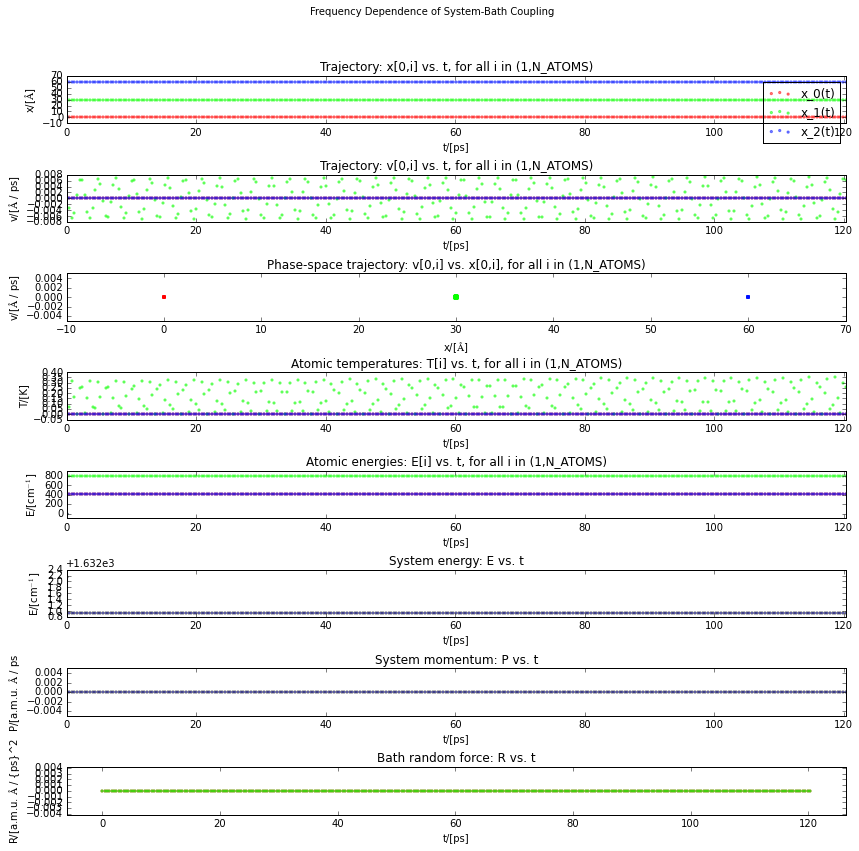

In [29]:
plotTrajectory()

## $NV\{T_1>T_2=0\}$ Markovian

In [30]:
D_T = float(10)
init(Delta_T=D_T)

initialization in progress:
$\Omega_D$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Omega_M$ = 0.0 cm$^{-1}$ --> 0.0 system units
$\Omega_B$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Gamma_B$ = 20.0 cm$^{-1}$ --> 0.2 system units
T_L = 0.06944444444444445
Baths initialization completed
$V_0$ = 8000.0 cm $^{-1}$
$a$^{-1}$ = 10.0 $\AA$
$V_0a^2$ = 0.8
HARMONIC_APPROX? False
V0 * A$^2 = 0.8, STEPS_PER_PERIOD = 50, N_SLOW_PERIODS = 200.0
frequencies = [ 0.05  4.  ]
dt = 0.005 = 0.00014989622899999998 ps
slow_component_period = 20.0 = 0.599584916 ps
n_steps = 800000
Time initialization completed
[m] = <class 'numpy.ndarray'>, dim(m) =(3,)
[x] = <class 'numpy.ndarray'>, dim(x) =(3, 1)
v[:,0] = [ 0.  0.  0.]
a[:,0] = [ 0.  0.  0.]
PhaseData initialization completed
Initial configuration for 3 atoms in 1 dimensions:
t = 0.000000, t_n - 1 = 0.044969, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [ 0.]
t = 0.000000, t_n - 1 = 0.044969, i = 1, x[i] = [ 30.1], <x[i]> = 30.05108757207351, v[i] = [ 0.]
t = 0.

In [31]:
run_numba(debugWhat="effectiveGamma")

Silent? False Debug? False
Running 800000 time-steps:
0% done, unknown time left
t = 0.000000, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [ 0.008]
t = 0.000000, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -1.245e-06]
t = 0.000000, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i] = [ 0.]
$\delta x_K \delta x$ (K = 0) = ([ 0.] - [ 0.]) \times ([ 30.1] - [ 30.]) = [ 0.]
$\delta x_K \delta x$ (K = 1) = ([ 60.] - [ 60.]) \times ([ 30.1] - [ 30.]) = [ 0.]
$V_0 a^2 \times x^2 / v$[1] = 0.8 * [ 0.] / [ -1.245e-06]
0% done, 0:00:00.145240 left
t = 0.000150, t_n - 1 = 0.000000, i = 0, x[i] = [  8.009e-05], <x[i]> = 0.0, v[i] = [ 0.018]
t = 0.000150, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -3.734e-06]
t = 0.000150, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i] = [ 0.]
0% done, 0:00:00.062320 left
t = 0.000300, t_n - 1 = 0.000000, i = 0, x[

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:51: UserWarning: RuntimeError: system melted! (atom=2, angle=180.0 degrees, time=83155


(array([ 58.19]), 5826666.961194822, 54.88092700000004)

plotting x(t)
plotting v(t)
plotting v(x)
plotting T_i(t)
plotting E_i(t)
plotting E(t)
plotting P(t)
plotting R(t)
displaying plots:


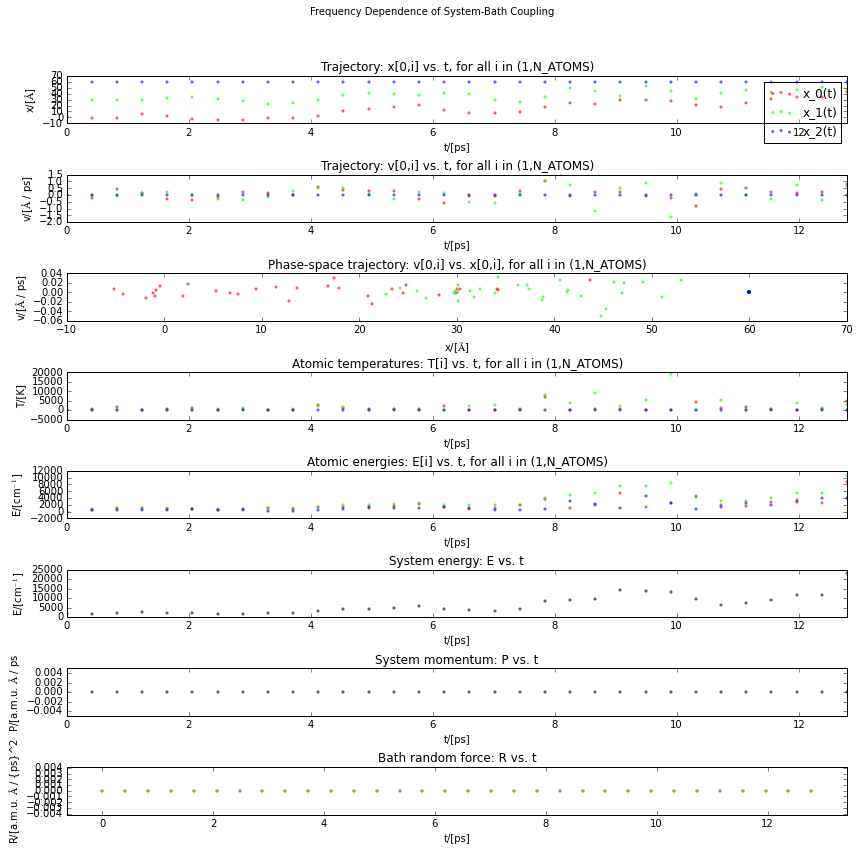

In [32]:
plotTrajectory()

## Analysis of the random force

In [33]:
print(Rt.shape)
print(Rt[0:5])
print(Rt[-5:])

(302, 2, 1)
[[[  7.212e-06]
  [  0.000e+00]]

 [[ -1.394e-05]
  [  0.000e+00]]

 [[ -7.397e-06]
  [  0.000e+00]]

 [[  1.111e-05]
  [  0.000e+00]]

 [[  1.044e-05]
  [  0.000e+00]]]
[[[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]]


In [34]:
aRt = abs(Rt)
print(aRt.shape)
print(aRt[0:5])
print(aRt[-5:])

(302, 2, 1)
[[[  7.212e-06]
  [  0.000e+00]]

 [[  1.394e-05]
  [  0.000e+00]]

 [[  7.397e-06]
  [  0.000e+00]]

 [[  1.111e-05]
  [  0.000e+00]]

 [[  1.044e-05]
  [  0.000e+00]]]
[[[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]

 [[ 0.]
  [ 0.]]]


In [35]:
print(aRt.max())
print(np.amax(aRt))
print(np.argmax(aRt))

0.059644530551
0.059644530551
64


### visualization (scatter plot)

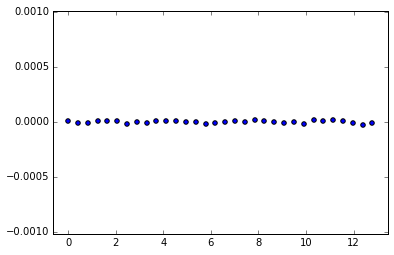

In [36]:
t_max = t_n * COARSE_GRAINING_RESOLUTION * dt / PICOSECONDS_TO_SYS_UNITS
t_grid = np.linspace(0, t_max, t_n)

plt.autoscale(tight=True)
plt.scatter(t_grid, Rt[:t_n,0,0])

### auto-convolution

In [37]:
def autoconvoluteRandomForce(isDebug=False):
    sig = Rt[:t_n,0,0]
    autocorr = np.convolve(sig, sig[::-1]) # list[::-1] means iterate backwards over list
    if isDebug:
        print("autocorr.shape = ", autocorr.shape)
    return autocorr

In [38]:
from scipy.optimize import curve_fit


def gaussian_fit(x, amp2, mu, sigma2):
    '''
    As a lambda expression:
    gaussian_fit = 
        lambda x, amp2, mu, sigma2: 
            math.sqrt(amp2) * 
            math.exp(-(x - mu) * (x - mu) / (2 * sigma2)) / 
            np.sqrt(2 * math.pi * sigma2)
            
    However, not that this function will be called for a range of 'x' values, and therefore 'x' is not a scalar.
    This can be mitegated by using np.sqrt and np.exp instead of the equivalent methods from the 'math' library.
    '''
    dx = x - mu
    dx2 = dx * dx
    # if not np.isscalar(dx2):
    #   raise RuntimeError("dx2 should be a scalar! {}".format(dx2.shape))
    twoSigma2 = 2 * sigma2
    return np.sqrt(amp2) * np.exp(-dx2 / twoSigma2) / np.sqrt(np.pi * twoSigma2)

def fitGaussianToRandomForce(sym_t_grid, autocorr):
    
    guessVariance = 2 * M_B * GAMMA_B * T_L
    guessParams = [1e-10, 0, guessVariance * guessVariance]
    if(N_ATOMS > t_n):
        raise RuntimeError("len(guessParams) == {} > {} == t_n . Too few samples to perform fit of this many variables!".format(len(guessParams), t_n))
    fitParams, fitCovar = curve_fit(gaussian_fit, sym_t_grid, autocorr, p0=guessParams)

    print("amplitude",math.sqrt(guessParams[0]), "-->", math.sqrt(fitParams[0]))
    print("mu",guessParams[1], "-->", fitParams[1])
    print("sigma", math.sqrt(guessParams[2]), "-->", math.sqrt(fitParams[2]))
    print("covar", fitCovar)
    return fitParams, fitCovar

In [39]:
def plotGaussianFit():
    try:
        sym_t_grid = np.linspace(-t_max, t_max, 2 * t_n - 1)
        autocorr = autoconvoluteRandomForce()
        fitParams, fitCovar = fitGaussianToRandomForce(sym_t_grid, autocorr)
    except RuntimeError as rtException:
        warnings.warn(" ".join(["caught RuntimeError:", str(rtException)]))
        return
    
    plt.plot(sym_t_grid, autocorr)
    plt.plot(sym_t_grid, gaussian_fit(sym_t_grid, fitParams[0], fitParams[1], fitParams[2]))
    plt.xlabel("$\Delta$t/[ps]")
    plt.ylabel(r'$\langle R^2(\Delta t) \rangle$')
    plt.show()

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.4/dist-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


amplitude 1e-05 --> 2.2829773955842993e-09
mu 0 --> 2.49148940163e-10
sigma 0.4444444444444445 --> 0.24081421372495623
covar [[ inf  inf  inf]
 [ inf  inf  inf]
 [ inf  inf  inf]]


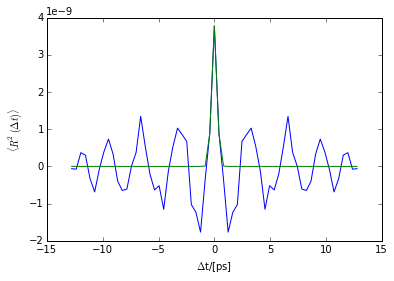

In [40]:
plotGaussianFit()

### frequency domain

In [41]:
from numpy import fft

def plotRandomForceFreqDom(out=None):
    out = fft.fft(Rt[:t_n,0,0])
    print(out.shape)
    plt.plot(out.real)
    plt.plot(out.imag)

(32,)


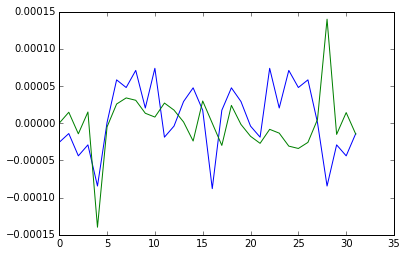

In [42]:
plotRandomForceFreqDom()

## $NV\{T_1>T_2=0\}$ Non-Markovian

In [43]:
"""
global N_SLOW_PERIODS
N_SLOW_PERIODS /= 16
"""
init(omega_M = float(400), Delta_T=D_T)

initialization in progress:
$\Omega_D$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Omega_M$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Omega_B$ = 400.0 cm$^{-1}$ --> 4.0 system units
$\Gamma_B$ = 20.0 cm$^{-1}$ --> 0.2 system units
T_L = 0.06944444444444445
Baths initialization completed
$V_0$ = 8000.0 cm $^{-1}$
$a$^{-1}$ = 10.0 $\AA$
$V_0a^2$ = 0.8
HARMONIC_APPROX? False
V0 * A$^2 = 0.8, STEPS_PER_PERIOD = 50, N_SLOW_PERIODS = 200.0
frequencies = [ 0.05  4.    4.  ]
dt = 0.005 = 0.00014989622899999998 ps
slow_component_period = 20.0 = 0.599584916 ps
n_steps = 800000
Time initialization completed
[m] = <class 'numpy.ndarray'>, dim(m) =(3,)
[x] = <class 'numpy.ndarray'>, dim(x) =(3, 1)
v[:,0] = [ 0.  0.  0.]
a[:,0] = [ 0.  0.  0.]
PhaseData initialization completed
Initial configuration for 3 atoms in 1 dimensions:
t = 0.000000, t_n - 1 = 0.004647, i = 0, x[i] = [ 0.], <x[i]> = 43.67953521980495, v[i] = [ 0.]
t = 0.000000, t_n - 1 = 0.004647, i = 1, x[i] = [ 30.1], <x[i]> = 47.1322583901551

In [44]:
run_numba()

Silent? False Debug? False
Running 800000 time-steps:
0% done, unknown time left
t = 0.000000, t_n - 1 = 0.000000, i = 0, x[i] = [ 0.], <x[i]> = 0.0, v[i] = [-0.]
t = 0.000000, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -1.245e-06]
t = 0.000000, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i] = [ 0.]
0% done, 0:00:00.074360 left
t = 0.000150, t_n - 1 = 0.000000, i = 0, x[i] = [ -1.602e-06], <x[i]> = 0.0, v[i] = [-0.001]
t = 0.000150, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -3.734e-06]
t = 0.000150, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.02250562640660165, v[i] = [ 0.]
0% done, 0:00:00.064220 left
t = 0.000300, t_n - 1 = 0.000000, i = 0, x[i] = [ -5.054e-06], <x[i]> = 0.0, v[i] = [-0.001]
t = 0.000300, t_n - 1 = 0.000000, i = 1, x[i] = [ 30.1], <x[i]> = 0.011290322580645162, v[i] = [ -6.223e-06]
t = 0.000300, t_n - 1 = 0.000000, i = 2, x[i] = [ 60.], <x[i]> = 0.0

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:51: UserWarning: RuntimeError: system melted! (atom=2, angle=180.0 degrees, time=59484


(array([ 30.071]), 2666019.434957191, 27.70235600000001)

plotting x(t)
plotting v(t)
plotting v(x)
plotting T_i(t)
plotting E_i(t)
plotting E(t)
plotting P(t)
plotting R(t)
displaying plots:


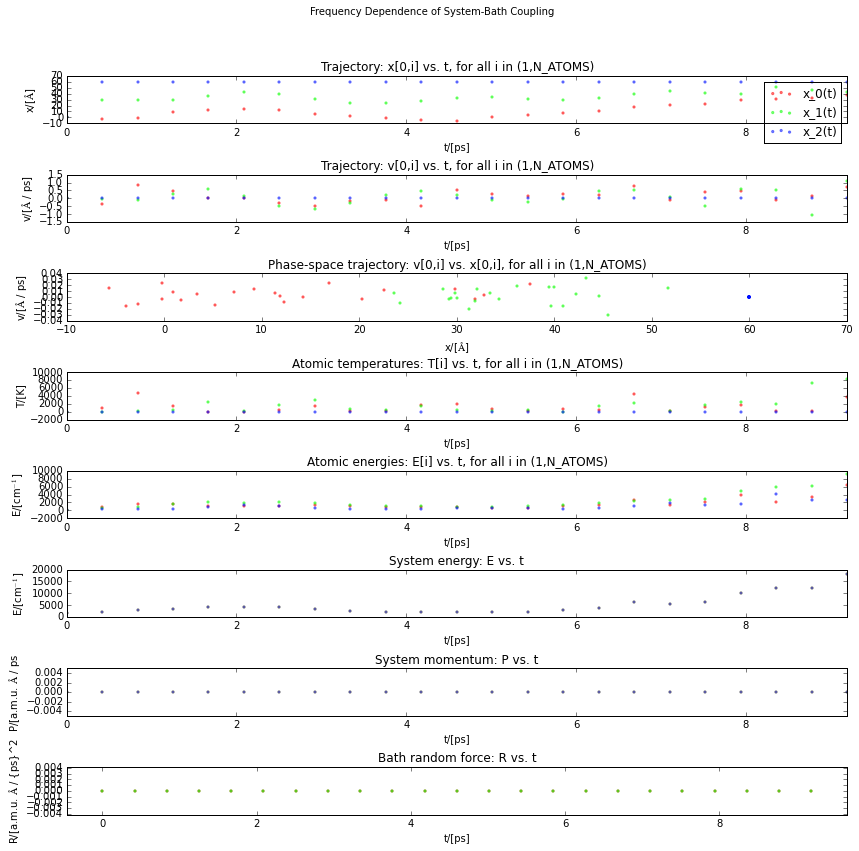

In [45]:
plotTrajectory()

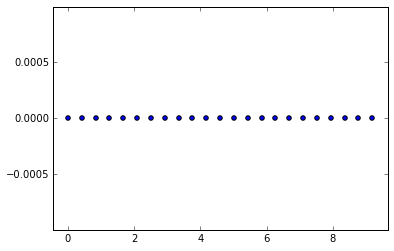

In [46]:
t_max = t_n * COARSE_GRAINING_RESOLUTION * dt / PICOSECONDS_TO_SYS_UNITS
t_grid = np.linspace(0, t_max, t_n)

plt.autoscale(tight=True)
plt.scatter(t_grid, Rt[:t_n,0,0])

(23,)


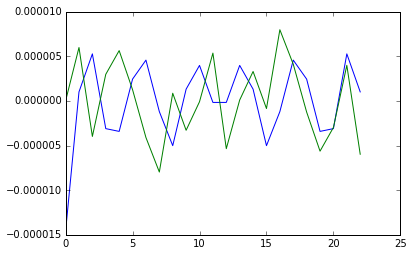

In [47]:
plotRandomForceFreqDom()

amplitude 1e-05 --> 2.5328747377877102e-11
mu 0 --> 1.34927569407e-09
sigma 0.4444444444444445 --> 0.2645309121513654
covar [[ inf  inf  inf]
 [ inf  inf  inf]
 [ inf  inf  inf]]


/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.4/dist-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


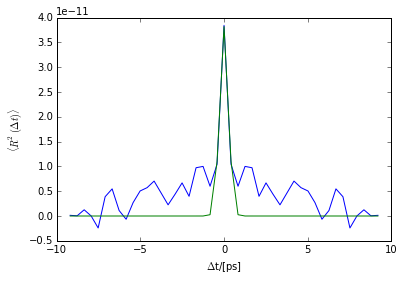

In [48]:
plotGaussianFit()

# Scan over 'bath-particle' mass to extrapolate low-frequency dependence

In [49]:
OMEGA_M=0
A=float(4)

In [50]:
MAX_ALLOWED_TIME_STEPS = 1e7
N_SLOW_PERIODS = float(100) * 2 # ~ 30 seconds wall-clock time per simulation
N_SLOW_PERIODS *= 2
n_points = 4

$
\begin{align}
\log_x (0.50 / 0.01) &= n_{points} = 100 \\
\ln (0.50 / 0.01) / \ln x &= 100 \\
\ln (0.50 / 0.01) / 100 &= \ln x \\
x &= \exp (\ln (0.50 / 0.01) / 100) \approx 103.76\% \\
\end{align}
$

In [51]:
#np.set_printoptions(precision=3)
base = math.exp(math.log(0.40 / 0.01) / n_points)
print(base)

2.514866859365871


In [52]:
couplingFrequencyDependence = np.zeros(shape=(n_points, 3)) # 2-D matrix: first column is frequency, second column is avg. Gamma, third column is Gamma Std. Dev. error estimate

m_0 = 1
if (1 > m_0):
    raise RuntimeError("initial bath atom mass ({}) must be greater than one for scan!".format(m_0))

for i in range(n_points):
    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    m_0 *= base
    print(" starting i = {} (m_0 = {})".format(i, m_0))
    
    init(m0=m_0, isDebug=False)        
    GammaAvg, GammaSD, simulation_duration = run_numba(isSilent=True)
    
    if (np.isclose(GammaSD, 0)):
        raise RuntimeError("standard deviation of effective Gamma is zero!")
    
    omega = math.sqrt(V0A2 / M0)
    couplingFrequencyDataPoint = [omega, GammaAvg, GammaSD]
    # print(couplingFrequencyDataPoint)
    couplingFrequencyDependence[i] = couplingFrequencyDataPoint
    
    print(" finished i = {} (m_0 = {}) {}".format(i, m_0, couplingFrequencyDataPoint))    
    weight_previous = 0.5 # change to exponentially decaying weight, i.e. weight_previous ~ math.exp(-1 * (i + 1))
    if (0 > weight_previous) or (1 < weight_previous):
        raise RuntimeError("weight of previous runs must be in the domain (0,1)!")
    time_left = time_elapsed * weight_previous + simulation_duration * (1 - weight_previous)
    time_elapsed += simulation_duration
    print("{} left".format(datetime.timedelta(seconds=time_left)))

    
print("\ndone!")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 starting i = 0 (m_0 = 2.514866859365871)
initialization in progress:
Baths initialization completed
frequencies = [ 80.   4.]
dt = 0.00025 = 7.49481145e-06 ps
n_steps = 800000
Time initialization completed
PhaseData initialization completed
Outputs initialization completed
MD initialization completed
initialization completed
Silent? True Debug? False
Running 800000 time-steps:
0% done, unknown time left
0% done, 0:00:00.037440 left
0% done, 0:00:00.036660 left
Final configuration:
t = 0.147933, t_n - 1 = 0.000052, i = 0, x[i] = [-0.933], <x[i]> = -6.824088748123505, v[i] = [ 14.131]
t = 0.147933, t_n - 1 = 0.000052, i = 1, x[i] = [ 1.503], <x[i]> = -5.424474064886288, v[i] = [ 13.761]
t = 0.147933, t_n - 1 = 0.000052, i = 2, x[i] = [ 1.5], <x[i]> = 1.5, v[i] = [ 0.]
simulated time = 5.99584916 ps
simulation wall-clock duration = 0:00:00.003705
time dilation = 6.2e+10%
9.71e+04 ps p

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:51: UserWarning: RuntimeError: system melted! (atom=2, angle=180.0 degrees, time=19738


NameError: name 'time_elapsed' is not defined

In [ ]:
def plotCouplingFrequency(couplingFrequencyDependence):
    """
    Plots the effective $\Gamma(\omega)$ applied to the molecular atom/s
    """
    plt.xlabel(str(r'$\omega / cm^{-1}$'))
    plt.ylabel(str(r'$\Gamma_{eff.} / cm^{-1}$'))
    plt.plot(couplingFrequencyDependence[:,0],couplingFrequencyDependence[:,1])
    ymin, ymax = ylim()
    plt.errorbar(couplingFrequencyDependence[:,0],couplingFrequencyDependence[:,1], yerr=couplingFrequencyDependence[:,2],fmt='r:') # consider using fill_between instead
    ylim(ymin=0,ymax=ymax)
    plt.show()

http://stackoverflow.com/a/22365754

In [ ]:
print(couplingFrequencyDependence)
plotCouplingFrequency(couplingFrequencyDependence)